# **ECG Practice**

## **Detección de casos de enfermedad cardiovascular a través del análisis de electrocardiogramas (ECG)**

---

**Referencia**: [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

**Resumen de la referencia**:

A partir de los datasets de  *PhysionNet’s MIT-BIH* y *PTB Diagnostics* se consigue realizar una clasificación de diferentes tipos de electrocardiogramas con una precisión del **93.4%** para las arritmias y **95.9%** para MI con el uso de RNN.

**Contenido**

* [importación de librerías y globales ](#section1)
* [análisis de datos](#section2)
    * Abrimos los datos
    * Vemos los tipos de datos, las primeras líneas del df y su distribución
    * Imprimimos algunos electrocardiogramas para ver qué pinta tienen
* [preprocesamiento](#section3)
    * Separamos el df en X,y
    * Creamos arrays con los índices de los ejemplos que pertenecen a cada categoría.
    * Vemos el counts por cada label, para ver su distribución.
* [visualización de datos](#section4)
    * plot del conteo por categoria, que visualizar la sobrerrepresentación de la label <0>
    * plot del valor medio de cada categoria y su rango de valores para cada timestamp
* [preparacion de datos](#section5)
    * Binarizamos las labels con OneHot
    * Hacemos un shuffle
    * Cambiamos las dimensiones
    * Hacemos un split entre train y test
* [definición de modelo CNN y entrenamiento](#section6)
    * importación de layers, callbacks, metrics y optimizersç
* [predicciones con el set de testeo](#section7)
* [evaluación del modelo](#section8)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



----
<a name="section1"></a>

### importación de librerias

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [28]:
%matplotlib inline

----
<a name="section2"></a>

### análisis de datos


In [29]:
local_data_path = "./data/mitbih_train.csv"
gcolab_data_path = "/content/drive/MyDrive/satAI/week_01/practice/data/mitbih_train.csv"

In [30]:
# step 1 - importar el dataset
df = pd.read_csv(gcolab_data_path, encoding='utf-8', header=None)

# step 2 - ¿qué forma tiene el dataset?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [31]:
# step 3 - ¿cómo son los datos? muestras las cinco primeras filas
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Este es el dataset de hoy. Esta vez, cada columna representa una lectura del electrocardiograma (recogido a 125Hz). 

Si en total hay 187 lecturas, en estas columnas tenemos alrededor de segundo y medio de pulsaciones. La última columna contiene la categoría a la que pertenecen estas pulsaciones. En total hay cinco, cada una representada por un número: 

- Normal: 0
- Arritmia prematura (atrial, aberrante-atrial, nodal o supra-ventricular) : 1
- Contracción prematura ventricular o escape ventricular: 2
- Fusión de la contracción ventricular y normal: 3
- Resucitación, fusión de normal y resucitación o inclasificable: 4


In [32]:
label_names = ('normal', 'arritmia_prematura', 'contracción_prematura_ventricular', 'fusión_contraccion_ventricular', 'resucitación')

In [33]:
# step 4 - Distribución de los datos
df.describe()

# NOTAS: 
# La columna de las labels tiene max = 4 (0..4 etiquetas), std = 1.14, 0.25,0.5,0.75 = 0

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


El rango para todas las columnas excepto para la ultima es de 0 .. 1 por lo que se trata de un dataset previamente normalizado.

En el paper de referencia se lo siguiente en referencia a la unificación de datos de las dos fuentes:

>The steps used for extracting beats from an ECG signal are as follows (see Fig. 1):
> 1. Splitting the continuous ECG signal to 10s windows andselect a 10s window from an ECG signal.
> 2. Normalizing the amplitude values to the range of between zero and one.
> 3. Finding the set of all local maximums based on zero crossings of the first derivative.
> 4. Finding the set of ECG R-peak candidates by applying a threshold of 0.9 on the normalized value of the local maximums.
> 5. Finding the median of R-R time intervals as the nominal heartbeat period of that window (T ).
> 6. For each R-peak, selecting a signal part with the length equal to 1.2T .
> 7. Padding each selected part with zeros to make its length equal to a predefined fixed length.

Es decir, del 'raw data' al que no tenemos acceso:
- Se seleccionaron ''windows'' de 10s cada uno
- Se normalizó y estandarizó el rango de los datos para que tuviesen la misma amplitud y duracción.

Cada ECG Beat que tenemos es una ponderación de un ''window'' dado de 10s procedente de dos fuentes.

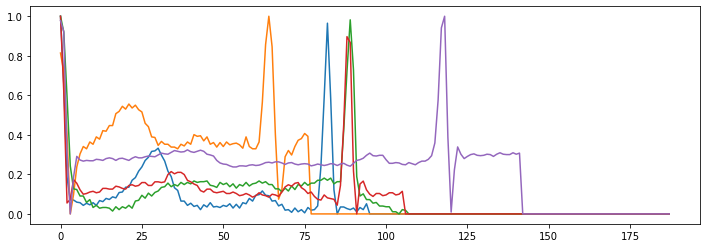

In [34]:
# step 5 - Cómo es cada uno de esos electrocardiogramas?

f, ax = plt.subplots(figsize=(12,4))

for _ in range(2, 100, 20):
    df.iloc[_, :].plot.line(ax = ax)

plt.show()

----
<a name="section3"></a>

### preprocesamiento

In [35]:
# step 1 - separación del frame en X (features) e y (labels)
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)

print(X.shape); print(y.shape)

(87554, 187)
(87554,)


In [36]:
# step 2 - creamos arrays con los índices de los ejemplos que pertenecen a cada categoría.

# opcion 1 - compatible con arrays
index_by_k = list(map(lambda k: np.argwhere(y.values == k).flatten(), y.unique()))
#index_by_k = list(map(lambda arr: np.reshape(arr, newshape=arr.size), index_by_k)) # esto se puede hacer conun faltten
# arrays -> lista dcon sublistas
# np.argwhere es en vertical mientras que np.where es en horizontal:

#       np.argwhere > [[[0], [1]], 
#                     [[2], [3]]]
#       np.where    > [([0, [], [2, 3],)]  # where is a tuple with (true_result, false_result)

# opcion 2 . con pandas - no sirve con arrays
index_by_label = list()

for _ in y.unique():
    index_by_label.append(df[df.iloc[:, -1] == _].index.tolist())

# 
print(index_by_k[0][:10])
print(index_by_label[0][:10])

[0 1 2 3 4 5 6 7 8 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [37]:
# step 3 - contamos cuanto ejemplos tenemos en cada categoría:

y.value_counts().sort_index().to_dict()

{0: 72471, 1: 2223, 2: 5788, 3: 641, 4: 6431}

De la categoria 3 (fusión_contraccion_ventricular) tenemos sólo 641 (< 1%) por lo que va a ser muy dificil de predecir; nuestro target es sobre todo el 0 y el 4 (arritmia y resucitación, que son los mencionados en el paper), que tienen, en orde, un 82.75% y un 7.35% de representación sobre el total de las labels.

----

<a name="section4"></a>

### visualización de datos

* Visualización del conteo 
* Rango de valores por cada electrocardiograma.

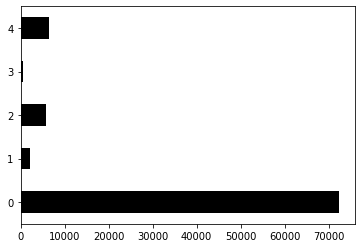

In [38]:
f, ax = plt.subplots()
ax = y.value_counts().sort_index().plot.barh(color = 'k')
plt.show()

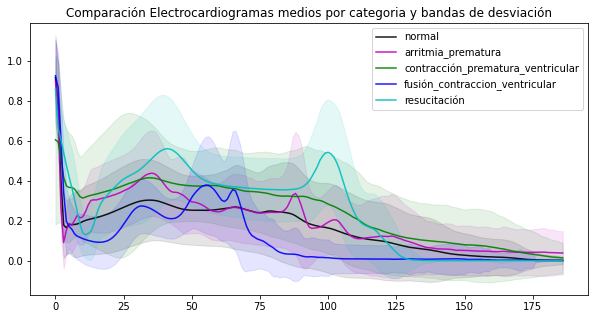

In [39]:
# Comparamos gráficamente los electrocardiogramas, dibujando el valor medio para cada tipo y su rango de valores.

f, ax = plt.subplots(figsize = (10,5))
colors = ['k', 'm', 'g', 'b', 'c']

for k in range(y.unique().size):
    mean = X.iloc[X.index.isin(index_by_k[k]), :].mean()
    stdev = X.iloc[X.index.isin(index_by_k[k]), :].std()

    ax.plot(mean, color = colors[k], alpha = 0.9, label = label_names[k])
    ax.fill_between(mean.index, mean-stdev, mean+stdev, color = colors[k], alpha = 0.1)
    ax.legend()

plt.title('Comparación Electrocardiogramas medios por categoria y bandas de desviación')
plt.show()

---
<a name="section5"></a>

### preparacion de datos

Existen varias formas de binarizar las labels: 

* OneHotEncoding: devuelve una matrix en la forma one-hot; funciona con multilabels.
    * Se aplica en casos cuando las labels no son ordinales
    * Los valores no son cercanos entre ellos (no lineales)
    
* LabelBinarizer / MultiLabelBInarizer: devuelve una matriz en la forma one-vs-all, toma cada input como una clase (no funciona con multilabels)
    * En casos en que las labels sean ordinales (tengan un orden entre ellas)
    * Cuando necesitemos asignar numeros cercanos para categorías similares.

Estos casos funcionan bien cuando no tenemos muchas labels, si no, nos encontramos n el problema de una alta dimensionalidad; en estos casos:
* LabelEncoder: devuelve un array; pero en los casos de que no haya ordinalidad, implica que el mean() del array es un valor no significativo.

In [40]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

STATE = 42

In [41]:
# ------------ INTERLUDE -----------------------------
# no conocías np.newaxis 
a = y.values[np.newaxis, :].shape
b = y.values[:, np.newaxis].shape # == np.argwhere 

print(a, end='\t'); print(b)

(1, 87554)	(87554, 1)


In [42]:
# %%timeit

# option 1 - OneHotENcoder     -  57.8 ms  ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# opcion 2- pd.get_dummies()   -  1.73 ms  ± 60.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

y = y.apply(lambda f: str(int(f))) 

enc = LabelBinarizer()

y_bin = enc.fit_transform(y) # devuelve un tensor
y_labels = enc.classes_

print(y_labels) # devuelve un tensor

['0' '1' '2' '3' '4']


In [43]:
# Una vez que tenemos la binarización de y
# Hacemos un chequeo entre categorías:

is_unique = {l: (np.where(y_bin.T[i] == 1)[0] == index_by_k[i]).all() 
            for i, l in enumerate(y_labels)}

print(is_unique)

{'0': True, '1': True, '2': True, '3': True, '4': True}


In [44]:
print(y.shape, end = '\t'); print(y_bin.shape, end = '\t'); print(type(y_bin))

(87554,)	(87554, 5)	<class 'numpy.ndarray'>


In [45]:
# Randomizamos los frame de entrenamiento y target

X_shuffle, y_shuffle = shuffle(X, y_bin, random_state=STATE)

Para poder introducir los datos en el modelo, necesitamos que cada punto de información esté solo dentro del array (no podemos dar un array como valor). 

Antes teníamos los datos estructurados así:

> $ X = [[a_1,a_2,a_3...,a_n],[b_1,b_2,b_3...,b_n]...[z_1,z_2,z_3,z_n]] $

Para poder usarlos necesitamos aislar cada uno de esos valores, sin eliminar su agrupación por ejemplos. Es decir:

> $ X = [[[a_1],[a_2],[a_3]...,[a_n]],[[b_1],[b_2],[b_3]...,[b_n]]...[[z_1],[z_2],[z_3],[z_n]] $

In [46]:
#%%timeit
# matrix X : 
# [   [row_1]  # size = 187 (n_cols)  
#     [row_2]  # size = 187 (n_cols)    
# ]   -------  # size = 16372598 (n_rows)
Xc = np.expand_dims(X_shuffle, axis = 2)
# 3.38 µs ± 104 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

In [47]:
X_shuffle = Xc
print(X_shuffle.shape); print(y_shuffle.shape)
print(type(X_shuffle)); print(type(y_shuffle))

(87554, 187, 1)
(87554, 5)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Una vez que hemos hecho todo, hacemos un train_test_split()

In [137]:
X_train, X_test, y_train, y_test = train_test_split(
    X_shuffle, y_shuffle, 
    test_size = .2, 
    random_state = STATE
)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, 
    test_size = .2, 
    random_state = STATE
)

----
<a name="section6"></a>

###  definición de modelo y entrenamiento

En el paper, pg.4, se plantea un modelo de CNN basado en 5 capas convolucionales que copiamos a continuación:

In [49]:
import keras

# layers used for CNN
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Input
from keras.models import Sequential, Model
from keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# metrix
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

In [112]:
signal_length = X_shuffle.shape[1]  # cada pulsación se compone de 187 señales --> longitud de la capa de entrada
n_classes =     y_labels.size       # y_labels es un range(0,5) obtenido en MultiLabelBinarizer() --> longitud de la capa final
batch_size =    192                 # p.e.

Siguiendo la arquitectura mencionada en el paper definimos una red neuronal con:
* 5 capas ocultas convolucionales de una dimension, con 32 neuronal y un kernel_size de 5.
> NOTA: se definen dos convolucionales con una activación en medio de relu y sin dropout, en vez de eso se mete un stride = 2; no se puede implementar la arquitectura mencionada por error de dimensión negativa
* Como layers vistas hay:
    * De entrada una Conv1D de 32 neuronas
    * De salida, 2 fully-connected de 32 neuronas con activación sigmoide y softmax

In [120]:
from keras import models
# -------------- MODEL ARCHITECTURE
# NOTE: Followed paper as much as possible
# API type. Sequential


def add_conv(i:int):
  """ Deep conv architecture; it is not exactly the architecture from the paper, but works fine:
      Paper: conv1D -> relu -> conv1D -> + -> relu -> pool1D
  """
  name = f'conv_layer_{i}'
  conv_layer = Sequential(
      [
        Conv1D(32, (4)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling1D(pool_size=(2))
      ], name=name
  )
  return conv_layer


def add_input_layer():
  """ Architecture for the first later in the model as given in the paper:
          conv1d -> relu
  """
  
  name = 'initial_layer'

  ini_layer = Sequential(
      [
          Conv1D(32, kernel_size=(5)),
          Dropout(0.15),
          BatchNormalization(), 
          Activation('relu'), 
      ], name=name
  )
  return ini_layer


def add_output_layer():
  """ Architecture for the last layer as given in the paper
          FullyConnected -> ReLu -> Dense -> Softmax
  """

  name = 'output_layer'

  output_layer = Sequential(
      [
        Dense(48, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax'),
      ], name=name
  )
  return output_layer


def get_model(signal_length:int=signal_length, n_classes:int=n_classes):
  """ Full architecture of the CNN following the top layer
  """
  model = Sequential()
  model.add(Input(shape = (signal_length, 1)))

  model.add(add_input_layer())

  for i in range(1,6):
    model.add(add_conv(i))
  
  model.add(Flatten())
  model.add(add_output_layer())

  return model


In [138]:
model = get_model()
loss  = CategoricalCrossentropy() # probabilistic loss
optimizer = Adam(    
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999)  # Paper: 0.001, 0.9, and 0.999

model.summary()
model.compile(
    loss = loss, 
    optimizer = optimizer,
    metrics = ['accuracy']
)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 initial_layer (Sequential)  (None, 183, 32)           320       
                                                                 
 conv_layer_1 (Sequential)   (None, 90, 32)            4256      
                                                                 
 conv_layer_2 (Sequential)   (None, 43, 32)            4256      
                                                                 
 conv_layer_3 (Sequential)   (None, 20, 32)            4256      
                                                                 
 conv_layer_4 (Sequential)   (None, 8, 32)             4256      
                                                                 
 conv_layer_5 (Sequential)   (None, 2, 32)             4256      
                                                                 
 flatten_15 (Flatten)        (None, 64)              

In [139]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=10
    ),
    ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.1,
        patience=5
    ),
    ModelCheckpoint(
        "/content/drive/MyDrive/satAI/week_01/practice/model/",
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="max"
    )
]

# 
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50, 
    batch_size=batch_size, 
    verbose=1,
    callbacks = callbacks
)

Epoch 1/50
438/438 [==============================] - 22s 45ms/step - loss: 0.4175 - accuracy: 0.8730 - val_loss: 0.6565 - val_accuracy: 0.8328 - lr: 5.0000e-04
Epoch 2/50
438/438 [==============================] - 19s 44ms/step - loss: 0.2009 - accuracy: 0.9458 - val_loss: 0.1523 - val_accuracy: 0.9563 - lr: 5.0000e-04
Epoch 3/50
438/438 [==============================] - 18s 40ms/step - loss: 0.1487 - accuracy: 0.9604 - val_loss: 0.1211 - val_accuracy: 0.9663 - lr: 5.0000e-04
Epoch 4/50
438/438 [==============================] - 15s 34ms/step - loss: 0.1231 - accuracy: 0.9678 - val_loss: 0.0994 - val_accuracy: 0.9722 - lr: 5.0000e-04
Epoch 5/50
438/438 [==============================] - 15s 33ms/step - loss: 0.1068 - accuracy: 0.9712 - val_loss: 0.0966 - val_accuracy: 0.9726 - lr: 5.0000e-04
Epoch 6/50
438/438 [==============================] - 18s 42ms/step - loss: 0.0950 - accuracy: 0.9738 - val_loss: 0.0936 - val_accuracy: 0.9741 - lr: 5.0000e-04
Epoch 7/50
438/438 [==============

----
<a name="section7"></a>

### evaluación del modelo

In [117]:
display(history.history.keys()) # aqui se ve que tiene el modelo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [118]:
get_cols_by_str = lambda s, df: df.columns[df.columns.str.contains(s)]

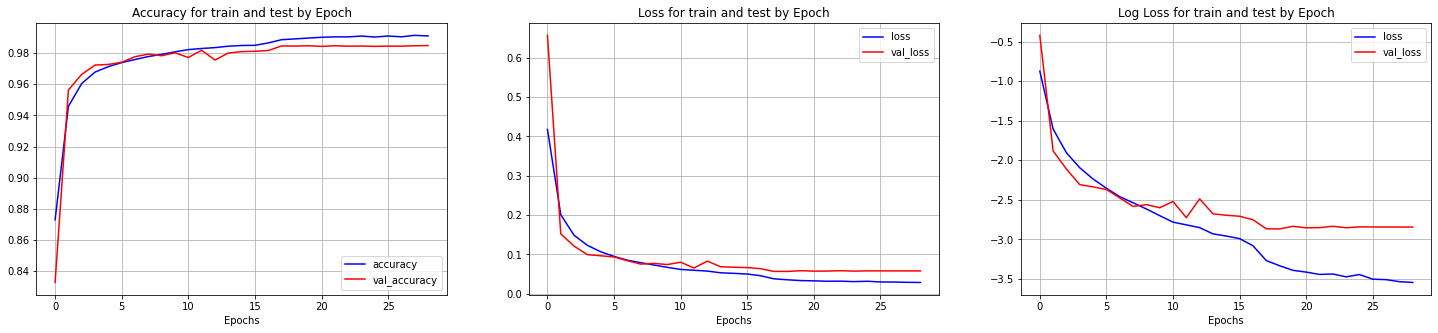

In [145]:
metrics = pd.DataFrame(history.history)

##############################
plot_args = {
    'color': ['blue','red'],
    'grid' : True,
    'xlabel': 'Epochs'
}

f, ax = plt.subplots(ncols = 3, figsize = (25,5))

metrics[get_cols_by_str(s='loss', df=metrics)].plot.line(ax = ax[1], title='Loss for train and test by Epoch', **plot_args)
metrics[get_cols_by_str(s='loss', df=metrics)].apply(np.log).plot.line(ax = ax[2], title='Log Loss for train and test by Epoch', **plot_args)
metrics[get_cols_by_str(s='accu', df=metrics)].plot.line(ax = ax[0], title='Accuracy for train and test by Epoch', **plot_args)

plt.show()

Notas:
* Las primeras tiradas, parece que tener tanto Dropout hace que el modelo no termine de aprender en todo su potencial
* La aproximación realizada de la arquitectura propuesta evita el overfitting pues val_loss < loss y accuracy < val_accuracy
* Quitando todos los dropout del modelo empieza en un accuracy del +90%
* Con dropouts de 15% y 30% en diferentes las convolucionales y la densa, respectivamente, se obtiene métricas aceptables.

In [126]:
def save_model(model):
    """Save the results of a model."""
    from datetime import datetime
    
    id = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
    model.save(f"huff_model_{id}.h5")

In [146]:
save_model(model)

----
<a name='#section8'></a>

### predict with test and validation


In [147]:
y_test_pred = model.predict(X_test)
y_val_pred = model.predict(X_validation)

In [148]:
model.evaluate(X_test, y_test)

548/548 [==============================] - 5s 8ms/step - loss: 0.0582 - accuracy: 0.9848


[0.05818129703402519, 0.9847524166107178]

In [149]:
model.evaluate(X_validation, y_validation)

438/438 [==============================] - 2s 5ms/step - loss: 0.0597 - accuracy: 0.9834


[0.05969390273094177, 0.9833678603172302]

In [151]:
print(y_test_pred.shape)
print(y_val_pred.shape)

(17511, 5)
(14009, 5)


Vamos a comprar `y_test_pred` de `y_test_true`

In [221]:
df_test_pred = pd.DataFrame(y_test_pred)
df_test_true = pd.DataFrame(y_test)

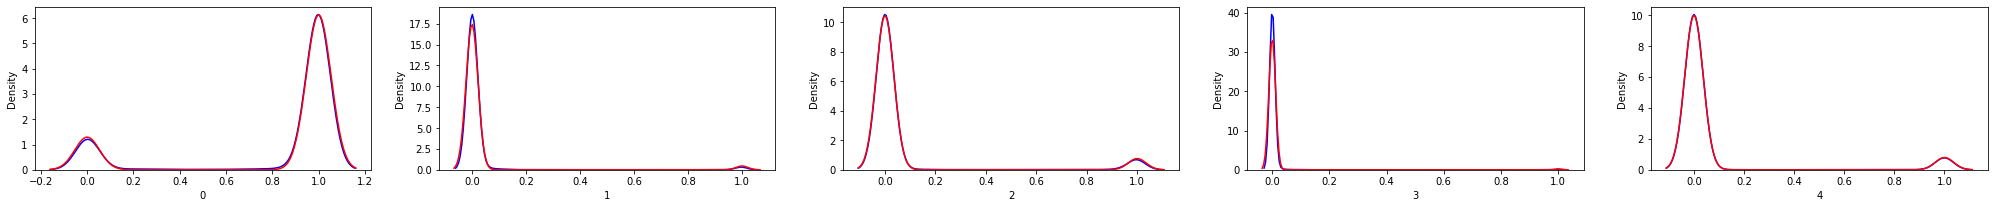

In [194]:
import seaborn as sns 
f, ax = plt.subplots(nrows = 1, ncols = n_classes, figsize = (35,3))

for i in range(0, n_classes):
  sns.kdeplot(df_test_pred[i], color = 'blue', ax = ax[i])
  sns.kdeplot(df_test_true[i], color = 'red', ax = ax[i])

plt.show()

classification_report genera un report del modelo:

In [220]:
print(classification_report(y_validation.argmax(axis=1), y_val_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11606
           1       0.90      0.78      0.84       339
           2       0.95      0.96      0.95       921
           3       0.91      0.66      0.77       104
           4       0.99      0.98      0.98      1039

    accuracy                           0.98     14009
   macro avg       0.95      0.88      0.91     14009
weighted avg       0.98      0.98      0.98     14009



In [222]:
from itertools import product

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion matrix, with normalization'


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



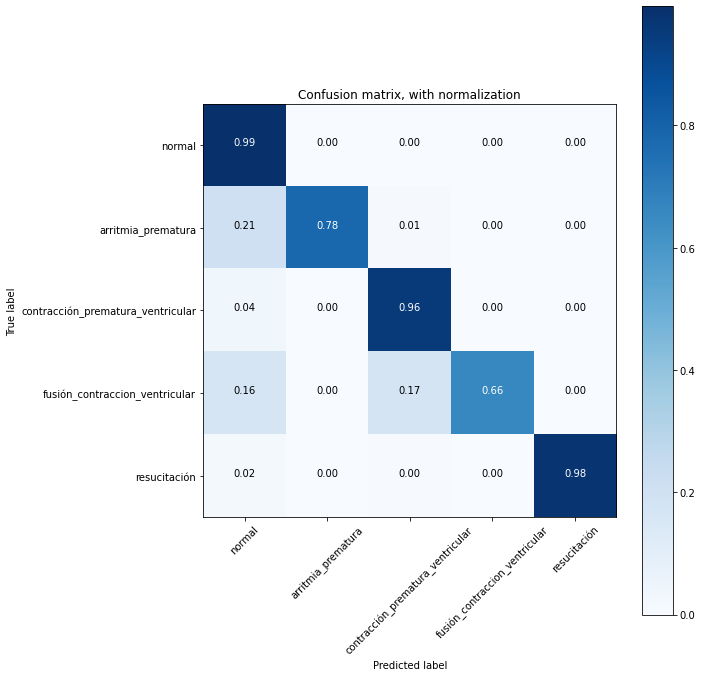

In [226]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_validation.argmax(axis=1), y_val_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=label_names,
                      title='Confusion matrix, with normalization',
                      normalize=True)
plt.show()

**Preguntas:**
- *Si tomamos todo lo que no sea normal como positivo, ¿el modelo se equivoca mas en falsos positivos o en falsos negativos?*
En **falso positivo**, pues devuelve como positivo (normal) casos que no pertenecen a esa categoría; sobre todo se equivoca cuando la label true pertenece a:
  * arritmia prematura
  * fusión contraccion ventricular 
- *¿Que categoría genera mayor error?*

 Fusión contracción ventricular, pues dos tercios de los casos están mal predecidos como normales contraccion prematura ventricular.

- *¿Existe overfitting?*
 En mi caso - que he modificado los parámetros de entrenamiento - creo que no; 
 ha ayudado mucho hacer la arquitectura del paper como modelo de seguimiento y ajustar el dropout

- ¿*Como afecta batch_size al entrenamiento?*
El batch size es el número de instancias que toma por cada época para entrenar; cuanto mayor batch size, mayor tiempo de entrenamiento por epoch y más rows tiene para entrenar, por lo que ayuda a bajar la posibilidad de overfitting.

- *¿El modelo plantea una sola posibilidad o las probabilidades de cada categoria al estimar?*

EL modelo plantea una probabilidad para cada categoría

Ahora os toca a vosotros mejorar el modelo. Probad con otros optimizadores, cambiar la función de coste, volveros locos con el batch_size..... El paper del principio puede dar alguna pista. Como siempre, el que tenga la mejor score, ¡tiene premio!

In [ ]:
# Lo he dejado en lo que he obtenido : 0.98 que no está mal